# The Battle of Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



---



## Introduction: Business Problem <a name="introduction"></a>


In this project I am going to find a safe and secure location for opening of commercial establishments in **Vancover**, Canada. Specifically, this report will be targeted to stakeholders interested in opening any business place like **Cafee Shop Store** in **Vancover City**, Canada.

The first task would be to choose the safest borough by analysing crime data for opening a Cafee Shop store and short listing a neighbourhood, where Cafee Shop stores are not amongst the most commom venues, and yet as safe to the stackholders as possible.

I will use the data science tools that I have learned in this course to analyse data and focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood where Cafee Shop store is not amongst the most common venue can be selected.

## Data <a name="data"></a>

Based on definition of the problem, factors that will influence the final decission are:
* finding the safest borough based on crime statistics
* finding the most common venues
* choosing the right neighbourhood within the borough

I will be using the geographical coordinates of Vancover to plot neighbourhoods in a borough that is safe and in the city's vicinity, and finally cluster all neighborhoods and present the findings.

Following data sources are used to extract the required information:

- [**Part 1**: Using a real world data set from Kaggle containing the Vancover Crimes from  2003 to 2019:](#part1):  A dataset consisting of the crime statistics of each Neighbourhoof in Vancover along with type of crime, recorded year, month and hour.

- [**Part 2**: Gathering additional information of the list of officially categorized boroughs in Vancover from Wikipedia.](#part2): Borough information will be used to map the existing data where each neighbourhood can be assigned with the right borough.

- [**Part 3**: Creating a new consolidated dataset of the Neighborhoods, along with their boroughs, crime data and the respective Neighbourhood's co-ordinates.](#part3): This data will be fetched using OpenCage Geocoder to find the safest borough and explore the neighbourhood by plotting it on maps using Folium and perform exploratory data analysis.

- [**Part 4**: Creating a new consolidated dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with co-ordinates.](#part4): This data will be fetched using Four Square API to explore the neighbourhood venues and to apply machine learning algorithm to cluster the neighbourhoods and present the findings by plotting it on maps using Folium.

### **Part 1:** Using a real world data set from Kaggle containing the Vancover Crimes report from  2003 to 2019<a name="part1"></a>


####  Vancover-crime-rate-per-neighbourhood

Data set URL:https://www.kaggle.com/agilesifaka/vancouver-crime-report

### Importing all the necessary Libraries


In [3]:
import numpy as np
import pandas as pd

#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

Matplotlib version:  3.1.1
Libraries imported


#### For simplicity, in this project I will consider the recent crime report of the 2019.

In [8]:
vnc_crime_df = pd.read_csv('https://raw.githubusercontent.com/ak1360/Capstone-Assignment/master/Vancover%20Crime%20Report.csv', index_col=None)

#Dropping X,Y which represents Lat, Lng data as Coordinates, the data seems to be corrupt
vnc_crime_df.drop(['MINUTE', 'HUNDRED_BLOCK', 'X', 'Y'], axis = 1, inplace = True)
vnc_crime_df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,NEIGHBOURHOOD
0,Break and Enter Commercial,2019,3,7,2,Fairview
1,Break and Enter Commercial,2019,8,27,4,West End
2,Break and Enter Commercial,2019,6,9,10,West End
3,Break and Enter Commercial,2019,1,6,1,West End
4,Break and Enter Commercial,2019,7,21,11,Central Business District


#### Changing the name of columns to lowercase

In [9]:
vnc_crime_df.columns = ['Type', 'Year','Month','Day','Hour','Neighbourhood']
vnc_crime_df.head()

,Type,Year,Month,Day,Hour,Neighbourhood
0,Break and Enter Commercial,2019,3,7,2,Fairview
1,Break and Enter Commercial,2019,8,27,4,West End
2,Break and Enter Commercial,2019,6,9,10,West End
3,Break and Enter Commercial,2019,1,6,1,West End
4,Break and Enter Commercial,2019,7,21,11,Central Business District


In [10]:
# Total Crimes in different Neighborhoods
vnc_crime_df['Neighbourhood'].value_counts()

Central Business District    10618
West End                      2864
Mount Pleasant                2219
Strathcona                    1928
Fairview                      1827
Grandview-Woodland            1613
Renfrew-Collingwood           1503
Kitsilano                     1426
Kensington-Cedar Cottage      1363
Hastings-Sunrise              1229
Sunset                         893
Riley Park                     828
Marpole                        771
Victoria-Fraserview            530
Killarney                      507
Oakridge                       491
Kerrisdale                     382
South Cambie                   367
Dunbar-Southlands              329
West Point Grey                323
Shaughnessy                    266
Arbutus Ridge                  263
Stanley Park                   167
Musqueam                        10
Name: Neighbourhood, dtype: int64



**Part 2:** Gathering additional information about the Neighborhood from Wikipedia<a name="part2"></a>

Created a dictionary of Neighborhood and based on data in the following [Wikipedia page](https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver).

In [12]:
# define the dataframe columns
column_names = ['Neighbourhood', 'Borough'] 

# instantiate the dataframe
vnc_neigh_bor = pd.DataFrame(columns=column_names)

vnc_neigh_bor['Neighbourhood'] = vnc_crime_df['Neighbourhood'].unique()

neigh_bor_dict = {'Central Business District':'Central', 'West End':'Central', 'Stanley Park':'Central', 'Victoria-Fraserview':'South Vancouver',
                  'Killarney':'South Vancouver', 'Musqueam':'South Vancouver', 'Mount Pleasant':'East Side', 'Strathcona':'East Side',
                  'Renfrew-Collingwood':'East Side', 'Grandview-Woodland':'East Side', 'Kensington-Cedar Cottage':'East Side', 'Hastings-Sunrise':'East Side',
                  'Sunset':'East Side', 'Riley Park':'East Side', 'Kitsilano':'West Side', 'Fairview':'West Side',
                  'Marpole':'West Side', 'Oakridge':'West Side', 'Dunbar-Southlands':'West Side', 'Kerrisdale':'West Side',
                  'Shaughnessy':'West Side', 'West Point Grey':'West Side', 'Arbutus Ridge':'West Side', 'South Cambie':'West Side'}

for row, neigh in zip(neigh_bor_dict, vnc_neigh_bor['Neighbourhood']):
  vnc_neigh_bor.loc[vnc_neigh_bor.Neighbourhood == row, 'Borough'] = neigh_bor_dict.get(row)

vnc_neigh_bor.dropna(inplace=True)

print("Total Neighbourhood Count",len(vnc_neigh_bor['Neighbourhood']),"Borough Count",len(vnc_neigh_bor['Borough'].unique()))

vnc_neigh_bor.head()

Total Neighbourhood Count 24 Borough Count 4


,Neighbourhood,Borough
0,Fairview,West Side
1,West End,Central
2,Central Business District,Central
3,Grandview-Woodland,East Side
4,Mount Pleasant,East Side


### Merging the Crime and Neighbourhood Data

In [13]:
vnc_boroughs_crime = pd.merge(vnc_crime_df,vnc_neigh_bor, on='Neighbourhood')

vnc_boroughs_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Borough
0,Break and Enter Commercial,2019,3,7,2,Fairview,West Side
1,Break and Enter Commercial,2019,4,21,16,Fairview,West Side
2,Break and Enter Commercial,2019,10,26,0,Fairview,West Side
3,Break and Enter Commercial,2019,3,27,8,Fairview,West Side
4,Break and Enter Commercial,2019,7,13,1,Fairview,West Side


#### Cleaning data (dropping NA rows)

In [14]:
vnc_boroughs_crime.dropna(inplace=True)
vnc_boroughs_crime['Borough'].value_counts()

Central            13649
East Side          11576
West Side           6445
South Vancouver     1047
Name: Borough, dtype: int64

## Methodology<a name="methodology"></a>


- [**1.Exploratory Data Analysis**:](#eda) Visualise the crime repots in different Vancouver boroughs to idenity the safest borough and normalise the neighborhoods of that borough. Then the result will be used to  find 10 most common venues in each neighborhood.


- [**2.Modelling**:](#mdl) To help stakeholders choose the right neighborhood within a borough, similar neighborhoods will be clustered (K - means) which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. 

### Explore Data
#### Pivoting the table to better understand the data by crimes per **borough**

In [20]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                774                               192   
East Side                              749                               881   
South Vancouver                         38                                81   
West Side                              403                               800   
All                                   1964                              1954   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2003        2473               7041              696   
East Side           1966        1492               4707              712   
South Vancouver      178          82                512               33   
West Side            842         819               2559              541   
All                 4989        4866              14819             1982   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      251   
East Side                    651   
South Vancouver               64   
West Side                    234   
All                         1200   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        6       
South Vancouver                                                  2       
West Side                                                        3       
All                                                             12       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        218    13649  
East Side                                                      412    11576  
South Vancouver                                                 57     1047  
West Side                                                      244     6445  
All                                                            931    32717

##### Merging the Pivoted Column with other columns


In [21]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total'}, inplace=True)

# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,774,192,2003,2473,7041,696,251,1,218,13649
1,East Side,749,881,1966,1492,4707,712,651,6,412,11576
2,South Vancouver,38,81,178,82,512,33,64,2,57,1047
3,West Side,403,800,842,819,2559,541,234,3,244,6445


#### Pivoting the table to better understand the data by crimes per **neighborhood**

In [22]:
vnc_crime_neigh = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_neigh

Year  \
Type                      Break and Enter Commercial   
Neighbourhood                                          
Arbutus Ridge                                      8   
Central Business District                        557   
Dunbar-Southlands                                 10   
Fairview                                         169   
Grandview-Woodland                               110   
Hastings-Sunrise                                  38   
Kensington-Cedar Cottage                          59   
Kerrisdale                                        21   
Killarney                                         26   
Kitsilano                                         75   
Marpole                                           56   
Mount Pleasant                                   200   
Musqueam                                           0   
Oakridge                                          25   
Renfrew-Collingwood                               53   
Riley Park                                        36   
Shaughnessy                                       13   
South Cambie                                      17   
Stanley Park                                       9   
Strathcona                                       180   
Sunset                                            73   
Victoria-Fraserview                               12   
West End                                         208   
West Point Grey                                    9   
All                                             1964   

                                                                      \
Type                      Break and Enter Residential/Other Mischief   
Neighbourhood                                                          
Arbutus Ridge                                            58       33   
Central Business District                               131     1579   
Dunbar-Southlands                                        51       47   
Fairview                                                 86      236   
Grandview-Woodland                                      131      317   
Hastings-Sunrise                                        118      206   
Kensington-Cedar Cottage                                116      256   
Kerrisdale                                               99       49   
Killarney                                                37       76   
Kitsilano                                               138      210   
Marpole                                                 103       93   
Mount Pleasant                                          121      286   
Musqueam                                                  1        3   
Oakridge                                                 97       54   
Renfrew-Collingwood                                     120      208   
Riley Park                                              101       93   
Shaughnessy                                              82       29   
South Cambie                                             47       43   
Stanley Park                                              3       21   
Strathcona                                              118      464   
Sunset                                                   56      136   
Victoria-Fraserview                                      43       99   
West End                                                 58      403   
West Point Grey                                          39       48   
All                                                    1954     4989   

                                                                           \
Type                      Other Theft Theft from Vehicle Theft of Bicycle   
Neighbourhood                                                               
Arbutus Ridge                      24                 92               22   
Central Business District        1996               5507              524   
Dunbar-Southlands                  23                150               22   


##### Merging the Pivoted Column with other columns

In [23]:
vnc_crime_neigh.reset_index(inplace = True)
vnc_crime_neigh.columns = vnc_crime_neigh.columns.map(''.join)
vnc_crime_neigh.rename(columns={'YearAll':'Total'}, inplace=True)

vnc_crime_neigh.head()

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Arbutus Ridge,8,58,33,24,92,22,12,0,14,263
1,Central Business District,557,131,1579,1996,5507,524,158,1,165,10618
2,Dunbar-Southlands,10,51,47,23,150,22,11,0,15,329
3,Fairview,169,86,236,281,763,210,43,0,39,1827
4,Grandview-Woodland,110,131,317,183,608,115,108,1,40,1613


### Basic Statistical

In [24]:
vnc_crime_cat.describe()

,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
count,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,491.000000,488.500000,1247.250000,1216.50000,3704.750000,495.500000,300.000000,3.000000,232.750000,8179.250000
std,346.220546,410.307608,893.547751,1016.49545,2807.220734,317.830668,248.766289,2.160247,145.330371,5637.159118
min,38.000000,81.000000,178.000000,82.00000,512.000000,33.000000,64.000000,1.000000,57.000000,1047.000000
25%,311.750000,164.250000,676.000000,634.75000,2047.250000,414.000000,191.500000,1.750000,177.750000,5095.500000
50%,576.000000,496.000000,1404.000000,1155.50000,3633.000000,618.500000,242.500000,2.500000,231.000000,9010.500000
75%,755.250000,820.250000,1975.250000,1737.25000,5290.500000,700.000000,351.000000,3.750000,286.000000,12094.250000
max,774.000000,881.000000,2003.000000,2473.00000,7041.000000,712.000000,651.000000,6.000000,412.000000,13649.000000


### Visualising Data

#### Sorting the data by crimes per neighborhood

In [25]:
vnc_crime_neigh.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = vnc_crime_neigh.iloc[1:6]
crime_neigh_top5

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
1,Central Business District,557,131,1579,1996,5507,524,158,1,165,10618
22,West End,208,58,403,472,1428,159,90,0,46,2864
11,Mount Pleasant,200,121,286,467,769,217,103,0,56,2219
19,Strathcona,180,118,464,119,789,106,89,1,62,1928
3,Fairview,169,86,236,281,763,210,43,0,39,1827


#### Five Neighborhoods with highest crime


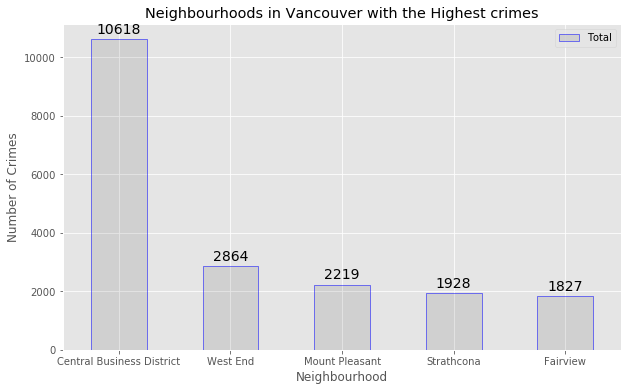

In [32]:
per_neigh = crime_neigh_top5[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

#### Five Neighborhoods with lowest crime

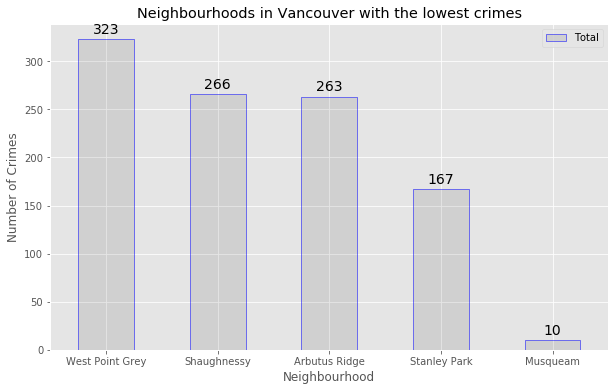

In [34]:
crime_neigh_low = vnc_crime_neigh.tail(5)


per_neigh = crime_neigh_low[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)


ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

#### Borough with Highest Crime in Vancouver


In [41]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                774                               192   
East Side                              749                               881   
South Vancouver                         38                                81   
West Side                              403                               800   
All                                   1964                              1954   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2003        2473               7041              696   
East Side           1966        1492               4707              712   
South Vancouver      178          82                512               33   
West Side            842         819               2559              541   
All                 4989        4866              14819             1982   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      251   
East Side                    651   
South Vancouver               64   
West Side                    234   
All                         1200   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        6       
South Vancouver                                                  2       
West Side                                                        3       
All                                                             12       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        218    13649  
East Side                                                      412    11576  
South Vancouver                                                 57     1047  
West Side                                                      244     6445  
All                                                            931    32717

In [42]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total',
                              'YearBreak and Enter Commercial' : 'Break and Enter Commercial',
                              'YearBreak and Enter Residential/Other' : 'Break and Enter Residential',
                              'YearMischief' : 'Mischief',
                              'YearOther Theft' : 'Other',
                              'YearTheft from Vehicle' : 'Theft from Vehicle',
                              'YearTheft of Bicycle' : 'Theft of Bicycle',
                              'YearTheft of Vehicle' : 'Theft of Vehicle',
                              'YearVehicle Collision or Pedestrian Struck (with Fatality)' : 'Vehicle Collision or Pedestrian Struck (with Fatality)',
                              'YearVehicle Collision or Pedestrian Struck (with Injury)' : 'Vehicle Collision or Pedestrian Struck (with Injury)'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,Break and Enter Commercial,Break and Enter Residential,Mischief,Other,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,774,192,2003,2473,7041,696,251,1,218,13649
1,East Side,749,881,1966,1492,4707,712,651,6,412,11576
2,South Vancouver,38,81,178,82,512,33,64,2,57,1047
3,West Side,403,800,842,819,2559,541,234,3,244,6445


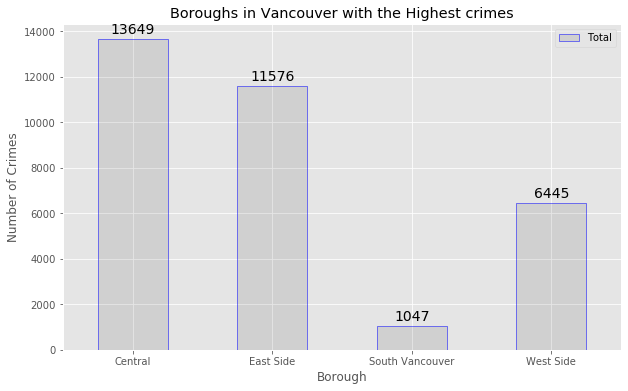

In [43]:
per_borough = vnc_crime_cat[['Borough','Total']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), rot=0,  color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

### Based on the graph it is clear that South Vancouver has the lowest crimes


##### Since South Vancouver has very little number of neighborhoods and opening a commercial establishment would not be viable, we can choose the next borough with lowest crime which is **West Side**.

### Different types of crimes recorded in the West Side Borough


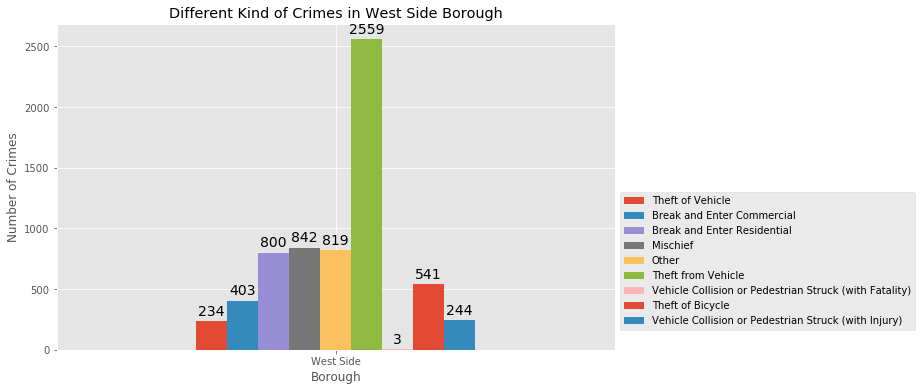

In [52]:
 vnc_ws_df = vnc_crime_cat[vnc_crime_cat['Borough'] == 'West Side']

 vnc_ws_df = vnc_ws_df.sort_values(['Total'], ascending = True, axis = 0)

vnc_ws = vnc_ws_df[['Borough','Theft of Vehicle', 'Break and Enter Commercial','Break and Enter Residential','Mischief','Other',
                 'Theft from Vehicle','Vehicle Collision or Pedestrian Struck (with Fatality)','Theft of Bicycle',
                 'Vehicle Collision or Pedestrian Struck (with Injury)']]


vnc_ws.set_index('Borough',inplace = True)

ax = vnc_ws.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Different Kind of Crimes in West Side Borough')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 14
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()


#### **West side** was chosen because crime type Break and enter Commercial is also low amongst other crimes types which makes West Side ideal destination for opening of commercial establishments